# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [1]:
import re
import os
import pickle
import spacy
import logging
import multiprocessing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from pathlib import Path
from collections import defaultdict, Counter
from spacy_langdetect import LanguageDetector
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [2]:
sns.set_style("darkgrid")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [3]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
non_alpha = re.compile("[^A-Za-z']+")
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)


In [4]:
model_id = "model_4"

if not os.path.exists(f'data/{model_id}'):
    os.mkdir(f'data/{model_id}')
clean_corpus_file = f'data/{model_id}/clean_texts.pkl'
model_file = f'data/{model_id}/word2vec.model'
bigrams_file = f'data/{model_id}/phrases'
trigrams_file = f'data/{model_id}/phrases_2'
vocabulary_file = f'data/{model_id}/vocabulary'
predicted_sentiment_file = f"data/{model_id}/predicted_sentiment.txt"
genre_counts_file = f"data/{model_id}/genre_counts.txt"
relative_abundance_file = f"data/{model_id}/relative_abundance.csv"
X_w2v_vectors_file = f"data/{model_id}/X_w2v_vectors.txt"
X_w2v_vectors_pickled_file = f"data/{model_id}/X_w2v_vectors.np"

In [5]:
df = pd.read_csv("data/380000-lyrics-from-metrolyrics.zip", header=0)
sentiment = pd.read_csv('data/SemEval2015-English-Twitter-Lexicon.txt', delimiter='\t', header=0,
                        names=['sentiment', 'term'])
sentiment.term = sentiment.term.str.replace('#', '')
sentiment.set_index('term', inplace=True)

In [6]:
# TODO: play with sentiment modifiers +/-
sentiment_terms = ['_'.join(i.split(' ')).replace("'", "_'_") for i in sentiment.index if ' ' in i]

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [7]:
# Clean texts

if not Path(clean_corpus_file).exists():
    def cleaning(doc):
        _txt = [token.text for token in doc if not token.is_stop]  # tokenize, remove stopwords, lowercase
        if len(_txt) > 2 and doc._.language["language"] == "en":
            return ' '.join(_txt)


    brief_cleaning = (non_alpha.sub(' ', str(row)).lower() for row in df.lyrics)  # Remove any non-alpha words

    t = time()
    texts = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=6)]
    pickle.dump(texts, open(clean_corpus_file, 'wb'))

    print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

texts = pickle.load(open(clean_corpus_file, 'rb'))

df_clean = pd.DataFrame({'clean': texts})
df['clean_lyrics'] = df_clean

print(df_clean.shape)

(362237, 1)


In [8]:
# Build Word2Vec model
if not Path(model_file).exists():
    sent = [row.split() for row in df['clean_lyrics'] if row]
    # Build collocations
    if not Path(bigrams_file).exists():
        bigram_phrases = Phrases(sent, min_count=30, progress_per=10000, max_vocab_size=200000,
                                 common_terms=sentiment_terms)
        bigram = Phraser(bigram_phrases)
        bigram.save(bigrams_file)
        trigram_phrases = Phrases(bigram[sent], min_count=30, progress_per=10000, max_vocab_size=200000,
                                  common_terms=sentiment_terms)
        trigram = Phraser(trigram_phrases)
        trigram.save(trigrams_file)

    trigram = Phrases.load(trigrams_file)

    sentences = trigram[sent]

    cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec(min_count=20,  # Remove rare words
                         window=2,
                         size=300,
                         sample=6e-5,
                         alpha=0.03,
                         min_alpha=0.0007,
                         negative=20,
                         workers=cores - 1)

    t = time()

    w2v_model.build_vocab(sentences, progress_per=10000)

    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
    w2v_model.vocabulary.save(vocabulary_file)

    t = time()

    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

    w2v_model.save(model_file)

trigram = Phrases.load(trigrams_file)
w2v_model = Word2Vec.load(model_file)

INFO - 17:33:19: loading Phrases object from data/model_4/phrases_2
INFO - 17:33:19: loaded data/model_4/phrases_2
INFO - 17:33:19: older version of Phrases loaded without corpus_word_count
INFO - 17:33:19: Setting it to 0, do not use it in your scoring function.
INFO - 17:33:19: loading Word2Vec object from data/model_4/word2vec.model
INFO - 17:33:20: loading wv recursively from data/model_4/word2vec.model.wv.* with mmap=None
INFO - 17:33:20: setting ignored attribute vectors_norm to None
INFO - 17:33:20: loading vocabulary recursively from data/model_4/word2vec.model.vocabulary.* with mmap=None
INFO - 17:33:20: loading trainables recursively from data/model_4/word2vec.model.trainables.* with mmap=None
INFO - 17:33:20: setting ignored attribute cum_table to None
INFO - 17:33:20: loaded data/model_4/word2vec.model


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [9]:
# Word2Vec sanity check

print(w2v_model.wv.most_similar(positive=["demon"]))
print(w2v_model.wv.most_similar(positive=["heaven"]))
print(w2v_model.wv.most_similar(positive=["best"]))

INFO - 17:33:28: precomputing L2-norms of word weight vectors


[('demons', 0.4987620711326599), ('devil', 0.4670695960521698), ('evil', 0.4538131356239319), ('beast', 0.41422775387763977), ('unholy', 0.38497433066368103), ('lucifer', 0.36358892917633057), ('soul', 0.3610911965370178), ('serpent', 0.3602025508880615), ('infernal', 0.35653674602508545), ('possessed', 0.3564806878566742)]
[('angel', 0.6091241240501404), ('heavens', 0.5625561475753784), ('angels', 0.526459813117981), ('paradise', 0.5221669673919678), ('lord', 0.5161783695220947), ('god', 0.5102301836013794), ('earth', 0.5082854628562927), ('hell', 0.48410823941230774), ('forever', 0.47051769495010376), ('sky', 0.46780771017074585)]
[('friend', 0.5785505771636963), ('guess', 0.5745936036109924), ("'cause", 0.5035116672515869), ('better', 0.49428194761276245), ('worst', 0.49144497513771057), ('know', 0.49054884910583496), ('thing', 0.4857170283794403), ('cause', 0.48455607891082764), ('friends', 0.4768590033054352), ('think', 0.4755038022994995)]


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [12]:
# TODO: distance compare
print(w2v_model.wv.most_similar(positive=["boy"], negative=["man"]))
print(w2v_model.wv.most_similar(positive=["boy"], negative=["man"]))
print(w2v_model.wv.most_similar(positive=["doctor"], negative=["man"]))
print(w2v_model.wv.most_similar(positive=["doctor"], negative=["woman"]))
print(w2v_model.wv.most_similar(positive=["love", "vodka"]))

print(w2v_model.wv.doesnt_match(["best", "good", "better", "god"]))

[('baby', 0.3250141739845276), ('girl', 0.31514260172843933), ('boys', 0.30278241634368896), ('urin', 0.2935744822025299), ('girls', 0.28977131843566895), ('ayeee', 0.28633373975753784), ('jiyoon', 0.2859916687011719), ('ttattatta', 0.2849035859107971), ('tches', 0.2840966582298279), ('motherfuckerin', 0.27856481075286865)]
[('baby', 0.3250141739845276), ('girl', 0.31514260172843933), ('boys', 0.30278241634368896), ('urin', 0.2935744822025299), ('girls', 0.28977131843566895), ('ayeee', 0.28633373975753784), ('jiyoon', 0.2859916687011719), ('ttattatta', 0.2849035859107971), ('tches', 0.2840966582298279), ('motherfuckerin', 0.27856481075286865)]
[('physician', 0.3655543327331543), ('jigeum', 0.34876883029937744), ('ohoho', 0.3225749731063843), ('palpitations', 0.31851503252983093), ('prescribe', 0.31004422903060913), ('curing', 0.30994242429733276), ('embalmed', 0.3090778589248657), ('purl', 0.3063126802444458), ('resuscitate', 0.3056427836418152), ('exhaled', 0.2893495559692383)]
[('phy

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

In [13]:
# Prepare sentiment for words found in sentiment dataset and w2v model
results = []
for v in sentiment.index.values:
    if v in w2v_model.wv:  # found in w2v by exact match
        results.append(np.array(w2v_model.wv[v]))
    elif '_'.join([i.lemma_ for i in nlp(v)]) in w2v_model.wv:  # found in w2v by lemma
        results.append(np.array(w2v_model.wv['_'.join([i.lemma_ for i in nlp(v)])]))
    else:  # not found in w2v
        results.append(None)

print(len(results))

print(np.array(results).shape)

t = np.concatenate((sentiment.reset_index(), np.array(results).reshape(1514, -1)), axis=1)
p = pd.DataFrame(t)
p = p[~p[2].isnull()]

1514
(1514,)


Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [14]:
# train linear regression model on using w2v vectors and known sentiment
X = p[2].values.tolist()
y = list(p[1].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
np.stack((model.predict(X_test), y_test), axis=1)

print(np.mean((y_train - model.predict(X_train)) ** 2))
print(np.mean((y_test - model.predict(X_test)) ** 2))


0.053395564988287215
0.18756624463289495


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [15]:
# predict sentiment for all the words in the w2v vocabulary
with open(predicted_sentiment_file, "wt") as f:
    for i, k in enumerate(w2v_model.wv.vocab):
        print(f"{k}:{model.predict([w2v_model.wv[k]])[0]}", file=f)

In [17]:
for i, k in enumerate(w2v_model.wv.vocab):
    if i > 200:
        break
    print(f"{k}:{model.predict([w2v_model.wv[k]])[0]}")

oh:0.36063021421432495
baby:0.44963324069976807
know:0.19668994843959808
gon:0.2881910800933838
na:0.3069486618041992
cut:-0.4009312689304352
right:0.2962903380393982
chase:0.22206874191761017
women:0.43918266892433167
like:0.20791923999786377
think:0.06277412176132202
created:0.3938867747783661
special:1.3889014720916748
purpose:0.30900731682777405
feel:0.14620980620384216
let:0.24733485281467438
lost:-0.42031124234199524
need:0.2930358946323395
work:0.19343990087509155
'cause:0.08416544646024704
boss:-0.6188192367553711
real:0.15683907270431519
want:0.29613780975341797
consider:-0.08157230913639069
lucky:0.6872429847717285
big:0.2689894735813141
deal:-0.20231720805168152
got:0.21211685240268707
key:0.6435457468032837
heart:0.43213602900505066
ai:0.005354620516300201
open:-0.028874196112155914
body:0.42212387919425964
secrets:0.13619521260261536
inside:-0.19215261936187744
lie:-0.520580530166626
wide:0.19447509944438934
strong:0.3149661421775818
wo:-0.23539942502975464
fit:-0.07483351

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

term
tennessee     1.892003e-14
cowboy        1.509771e-14
lonesome      1.397926e-14
teardrops     1.158335e-14
texas         1.092958e-14
sweetheart    1.039458e-14
whiskey       1.030946e-14
ole           1.026017e-14
cotton        1.023227e-14
county        1.014065e-14
Name: Country, dtype: float64
term
corpse       1.470730e-14
wrath        1.394828e-14
existence    1.390100e-14
eternal      1.388557e-14
mortal       1.341903e-14
decay        1.332385e-14
agony        1.300312e-14
chaos        1.297257e-14
mankind      1.289265e-14
humanity     1.278134e-14
Name: Metal, dtype: float64


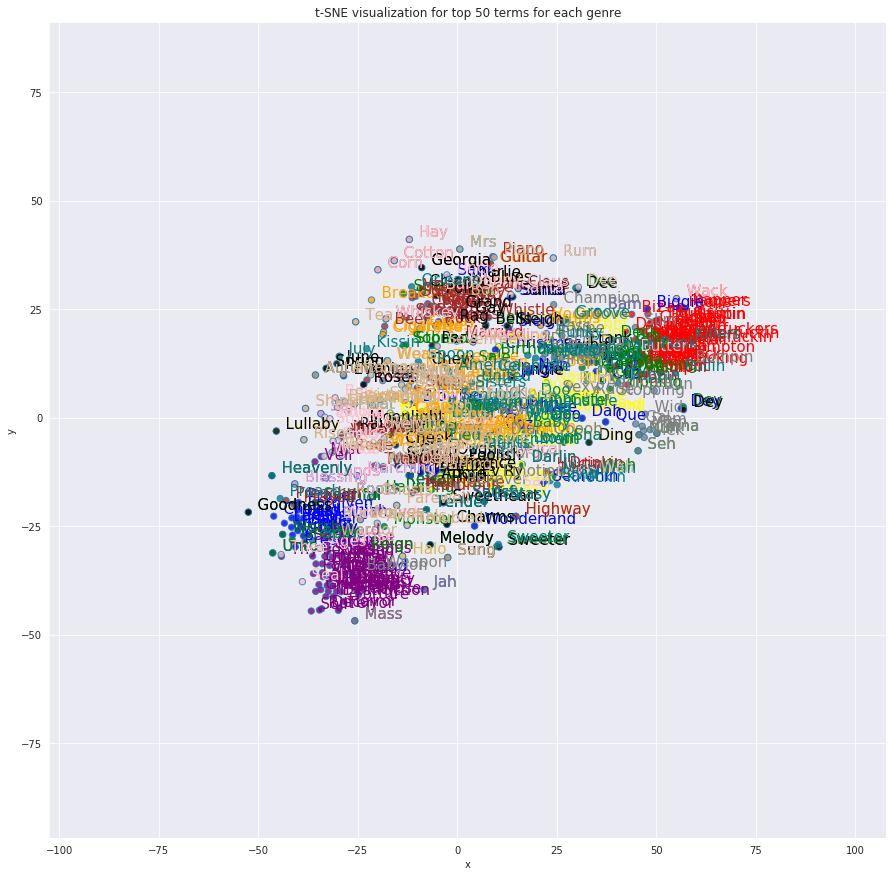

In [18]:
if not Path(genre_counts_file).exists():
    counts = defaultdict(Counter)

    for i, (k, v) in enumerate(df.iterrows()):
        if v.clean_lyrics:
            counts[v.genre] += Counter([t for t in v.clean_lyrics.split() if len(t) > 2])

    pickle.dump(counts, open(genre_counts_file, "wb"))
else:
    counts = pickle.load(open(genre_counts_file, "br"))

if not Path(relative_abundance_file).exists():
    total_count = Counter()
    for k in counts.keys():
        total_count += counts[k]

    total_elements = sum(total_count.values())

    top_3k = total_count.most_common(3000)

    results = []
    for w in top_3k:
        res = {"term": w[0], "proportion_in_corpus": w[1] / total_elements, }
        for k in counts.keys():
            res[k] = (counts[k][w[0]] / sum(counts[k].values())) / w[1] / total_elements
        results.append(res)

    relative_abundance_df = pd.DataFrame.from_records(results).set_index('term')
    relative_abundance_df.to_csv(relative_abundance_file)

relative_abundance_df = pd.read_csv(relative_abundance_file).set_index('term')

print(relative_abundance_df['Country'].sort_values(ascending=False)[:10])
print(relative_abundance_df['Metal'].sort_values(ascending=False)[:10])

genre_colors = zip(
    ['Pop', 'Hip-Hop', 'Not Available', 'Rock', 'Metal', 'Other', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B',
     'Indie'],
    ['yellow', 'red', 'blue', 'orange', 'purple', 'green', 'brown', 'black', 'grey', 'pink', 'teal', 'tan']
)

arrays = np.empty((0, 300), dtype='f')
word_labels = []
color_list = []

for genre, color in genre_colors:
    for word in relative_abundance_df[genre].sort_values(ascending=False)[:50].index:
        arrays = np.append(arrays, w2v_model.wv[word].reshape(1, 300), axis=0)
        word_labels.append(word)
        color_list.append(color)

# Reduces the dimensionality from 300 to 50 dimensions with PCA
reduc = PCA(n_components=50).fit_transform(arrays)

# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

# Sets everything up to plot
tnse_df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                        'y': [y for y in Y[:, 1]],
                        'words': word_labels,
                        'color': color_list})

fig, _ = plt.subplots()
fig.set_size_inches(15, 15)

# Basic plot
p1 = sns.regplot(data=tnse_df,
                 x="x",
                 y="y",
                 fit_reg=False,
                 marker="o",
                 scatter_kws={'s': 40,
                              'facecolors': tnse_df['color']
                              }
                 )

# Adds annotations one by one with a loop
for line in range(0, tnse_df.shape[0]):
    p1.text(tnse_df["x"][line],
            tnse_df['y'][line],
            '  ' + tnse_df["words"][line].title(),
            horizontalalignment='left',
            verticalalignment='bottom', size='medium',
            color=tnse_df['color'][line],
            weight='normal'
            ).set_size(15)

plt.xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
plt.ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)

plt.title('t-SNE visualization for top 50 terms for each genre')
plt.show()


## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [20]:
sklearn_pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=10000)),
    ('clf', MultinomialNB()),
])

y = list(df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().genre.values)
X = list(df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().clean_lyrics.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sklearn_pipeline.fit(X_train, y_train)

print("sklearn multinomial NB accuracy =", sum(sklearn_pipeline.predict(X_test) == y_test)/len(y_test))

y_pred = sklearn_pipeline.predict(X_test)

sklearn multinomial NB accuracy = 0.46740638002773927


Show the confusion matrix.

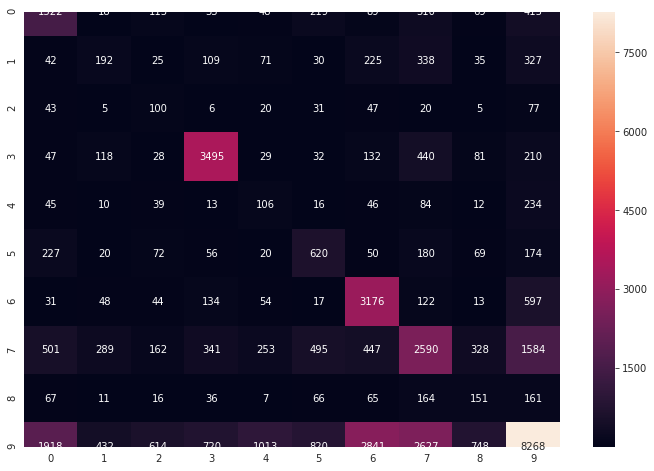

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.show()

Show the classification report - precision, recall, f1 for each class.

In [ ]:
# TODO

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [22]:
if not Path(X_w2v_vectors_file).exists():
    t = time()
    # X_vectors = np.empty((0, 300), dtype='f')
    with open(X_w2v_vectors_file, 'a') as f_handle:
        for song in X:
            song_arrays = np.empty((0, 300), dtype='f')
            for word in trigram[song.split()]:
                if word in w2v_model.wv:
                    song_arrays = np.append(song_arrays, w2v_model.wv[word].reshape(1, 300), axis=0)

            np.savetxt(f_handle, song_arrays.mean(axis=0))
        # X_vectors = np.vstack([X_vectors, song_arrays.mean(axis=0).reshape(1, 300)])
    print('Time to prepare mean vectors: {} mins'.format(round((time() - t) / 60, 2)))

    # X_vectors.dump(X_w2v_vectors_file)

    X_vectors = np.loadtxt(X_w2v_vectors_file)

    print(X_vectors.shape)
    X_vectors.dump(X_w2v_vectors_pickled_file)

X_vectors = np.load(X_w2v_vectors_pickled_file, allow_pickle=True).reshape(-1, 300)

X_vec = X_vectors[~np.any(np.isnan(X_vectors), axis=1)]
y_vec = np.array(y)[~np.any(np.isnan(X_vectors), axis=1)]

X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y_vec, test_size=0.2, random_state=42)

clf = ExtraTreesClassifier()
clf.fit(X_train_vec, y_train_vec)

print("sklearn ExtraTreesClassifier on W2V vectors accuracy =",
      sum(clf.predict(X_test_vec) == y_test_vec)/len(y_test_vec))
# 0.6246185852981969

sklearn ExtraTreesClassifier on W2V vectors accuracy = 0.6245954692556634


#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [23]:
print(len(texts) == len(df.genre.values))

X = pd.Series(texts).values[~pd.Series(texts).isnull()]
y = df.genre.values[~pd.Series(texts).isnull()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(analyzer=lambda x: x)
tfidf.fit([ii.split() for ii in X_train])
max_idf = max(tfidf.idf_)
word2weight = defaultdict(
    lambda: max_idf,
    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

train_transformed = np.array([
    np.mean([w2v_model.wv[w] * word2weight[w]
             for w in words if w in w2v_model.wv] or
            [np.zeros(300)], axis=0)
    for words in [ii.split() for ii in X_train]
])

test_transformed = np.array([
    np.mean([w2v_model.wv[w] * word2weight[w]
             for w in words if w in w2v_model.wv] or
            [np.zeros(300)], axis=0)
    for words in [ii.split() for ii in X_test]
])

clf = ExtraTreesClassifier()
clf.fit(train_transformed, y_train)
print("sklearn ExtraTreesClassifier on weighted W2V vectors accuracy =",
      sum(clf.predict(test_transformed) == y_test) / len(y_test))

True
sklearn ExtraTreesClassifier on weighted W2V vectors accuracy = 0.568427913626711


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [ ]:
# TODO